In [46]:
#! /usr/bin/env python
# encoding: utf-8
%matplotlib inline

##processing dependencies
import pandas as pd
import numpy as np
import itertools
import string
from collections import Counter

###plotting dependencies
import matplotlib.pyplot as plt
import seaborn as sns


##text processing dependencies
import jieba
import jieba.analyse
import unidecode
import re
from stopwords import *

from __future__ import print_function


import cPickle as pickle


##similarity metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist


###text vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

###clustering algorithms
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq


from sklearn.decomposition import PCA as sklearnPCA


### Load dataframes

In [68]:
%%time

###truncate/get random samples
df = pd.read_csv('data/week1.csv', header=0, low_memory=False).iloc[:5000]

CPU times: user 41.8 s, sys: 23.4 s, total: 1min 5s
Wall time: 1min 56s


### Pre-processing

In [69]:
stopwords = [x.decode('utf-8') for x in stopwords]

UnicodeEncodeError: 'ascii' codec can't encode character u'\u3002' in position 0: ordinal not in range(128)

In [72]:
##pre-processing helper functions


def cut_text(text) : return ",".join(jieba.cut_for_search(text, HMM=True))


def remove_ch(text): return "".join([x for x in text if x not in stopwords])


def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)


def clean(text) : return list(remove_ch(cut_text(text)))


#def check_null(text): return len(text) < 2 or text == 'nan'



def preprocess_pipe(df):
    df['text'] = df['text'].apply(lambda x : str(x))
    df['text'] = df['text'].map(lambda x : clean(x))
    df['text'] = df['text'].map(lambda x : x.replace(" ",""))
    df['text'] = df['text'].map(remove_punc)
    df[df['text'].map(len) < 2]
    df = df.drop_duplicates()
    return df


In [ ]:
%%time
clean_df = preprocess_pipe(df)

In [70]:
df.text

0                                                    转发微博
1            !!!!!!!!!@uK3RXUYW3： //@u0AGMTTVD：  ！！！！！！！！
2                                                求一切順利!!!
3                       想要><@uK3RXUYW3： //@ukn：  全都想要啊QAQ
4                            //@ukn：  //@uMLLV3ZCO：  转发微博
5       //@ukn：  //@ukn：  吐槽点太多- -//@ukn：  竟然没被吐槽//@uk...
6       係時侯迫害下大家~@uK3RXUYW3： @ukn： @ukn： @uQSMQTGXO： @...
7                                                 他又抽了xdd
8                                                     哈哈哈
9                  @uK3RXUYW3： //@ukn：  //@ukn：  [可怜][可怜]
10              太萌了><//@uKPK1KLQA：  边叠衣服边「味覚トゥッ~」也太萌了[发嗲]
11                                           //@ukn：  ！！！
12      霸气~//@ukn：  [太開心]//@uW0ECUEMG：  [good]//@ukn： ...
13      //@ukn：  //@uOQZ5JAJB：  5.利达从头到尾都很紧张的样子，让看着的我都...
14      //@ukn：  //@ukn：  //@uVEQEW1R2：  //@ukn：  [心][...
15      //@ukn：  美[花心]//@ukn：  @ukn： //@ukn：  //@uB4HS...
16             //@ukn：  //@uW0EHZTCF：  年末真好看//@ukn：  转发微博
17            

### Pipeline for K-means clustering

In [3]:
###function pipeline


##create tf-idf matrix
def tfidf(data):
    ##instantiate classifier
    tfidf_vectorizer = TfidfVectorizer(min_df=.01, max_df=.8, ngram_range=(1,2))
    #generate matrix
    k = tfidf_vectorizer.fit_transform(data)
    return tfidf_vectorizer.fit_transform(data) #fit the vectorizer to synopses


###run k-means on tf-idf matrix
def k_means(data, num_clusters):
    km = KMeans(n_clusters=num_clusters)
    km.fit(data)
    clusters = km.labels_.tolist()
    return km, clusters

##extract feature words
def feature_terms(data):
    tfidf_vectorizer = TfidfVectorizer(max_df=.8, min_df=.01, ngram_range=(1,2))
    #tfidf_vectorizer = TfidfVectorizer(max_df=.8, min_df=.01, ngram_range=(1,2))
    vectors = tfidf_vectorizer.fit(data)
    return tfidf_vectorizer.get_feature_names()

##find the terms with highest tf-idf score
def get_top_terms(km, review_terms, num_clusters):
    print("Top terms per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(1,num_clusters):
        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, :10]: #replace 11 with n words per cluster
            print(' %s' % review_terms[ind], end=',')
        print() #add whitespace
        print() #add whitespace

    print()
    print()


##run functions sequentially  
def pipeline(text, n_clusters):
    matrix = tfidf(text)
    km, clusters = k_means(matrix, n_clusters)
    features = feature_terms(text)
    terms = get_top_terms(km, features, n_clusters)
    return terms


pipeline(df.text, n_clusters=2)

NameError: name 'df' is not defined

### Pipeline for PCA

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def pca(text):
    X = tfidf(text).todense()
    
    color = ['r','b','g']

    pca = PCA(n_components=3).fit(X)
    data2D = pca.transform(X)
    plt.scatter(data2D[:,0], data2D[:,1], c=color)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("K-means Principal Components")
    plt.show()    

(11338, 88)


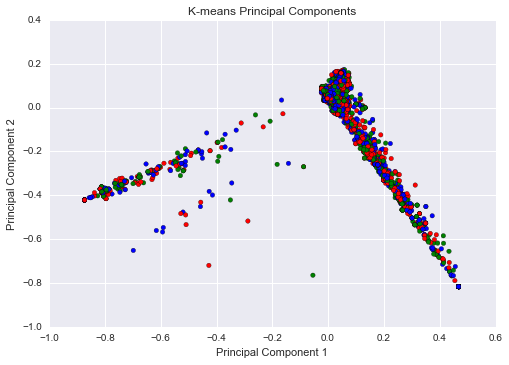

In [8]:
pca(weibo.text)

### Pipeline for LDA

In [ ]:
def lda_pipe(data, n_topics, n_top_words):
    
    n_features = 100
    data_samples = data
    n_topics = n_topics
    n_top_words = n_top_words
    
    

    def print_top_words(model, feature_names, n_top_words):
        terms = []
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
            terms.append(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
        return terms
        
    def lda_dict(model, feature_names, n_top_words):
        lda_dict = dict()
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            features, rank = [],[]
            features.append(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
            rank.append(topic[:-n_top_words-1:-1])
            d = dict(zip(features,rank))
            lda_dict[topic_idx] = {k:v for k,v in d.items()}
        return lda_dict

        

#     # Use tf-idf features for NMF.
#     print("Extracting tf-idf features for NMF...")
#     tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=.01) #max_features=n_features

#     tfidf = tfidf_vectorizer.fit_transform(data_samples)

    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=.01, max_features=n_features)

    tf = tf_vectorizer.fit_transform(data_samples)

#     # Fit the NMF model

#     nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)


#     print("\nTopics in NMF model:")
#     print()
#     print()
#     tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#     print_top_words(nmf, tfidf_feature_names, n_top_words)


    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=10,
                                    learning_method='online', learning_offset=50.,
                                    random_state=1)

    lda.fit(tf)


    print("\nTopics in LDA model:")
    print()
    print()
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    
    
lda_pipe(weibo.text, 6, 15)

In [ ]:
##modify function for application

def lda_generator(data_samples, n_top_words, n_topics):
    n_features = 100
    data_samples = data_samples
    n_topics = n_topics
    n_top_words = n_top_words
    
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=.01,ngram_range=(1,2), max_features=n_features)
    
    tf_matrix = tf_vectorizer.fit_transform(data_samples)
    
    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=10,
                                learning_method='online', learning_offset=50.,
                                random_state=1)
    lda.fit(tf_matrix)
    
    feature_names = tf_vectorizer.get_feature_names()
    
    terms_zh = []

    
    for topic_idx, topic in enumerate(lda.components_):
        lda_topics = (" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
        print(lda_topics)
        terms_zh.append(lda_topics)
        
    return terms_zh


In [ ]:
test = lda_generator(weibo.text, 10, 5)

### LDA Visual

### dataframe of tf-idf matrix

In [ ]:
def vector_df(corpus):
    vectorizer = CountVectorizer(ngram_range=(1,2))
    X = vectorizer.fit_transform(corpus).toarray()
    return pd.DataFrame(X,columns=vectorizer.get_feature_names())
vectorized_df = vector_df(weibo.text)

### Plot elbows and K-means clusters:

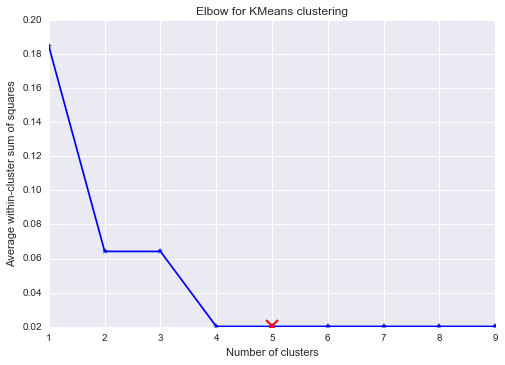

In [62]:
def plot_kmeans(data):
    tfidf = TfidfVectorizer(min_df=.01, ngram_range=(1,2))
    X = tfidf.fit_transform(data).todense()

    ##### cluster data into K=1..10 clusters #####
    K = range(1,10)

    # scipy kmeans module for each value of k:
    KM = [kmeans(X,k) for k in K]
    ##list comprehension to cluster centroids
    centroids = [cent for (cent,var) in KM]


    # alternative: scipy.spatial.distance.cdist
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]

    ##### plot ###
    kIdx = 4

    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='x', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')

    # scatter plot
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     #ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
#     clr = ['b','g','r','c','m','y','k']
#     for i in range(K[kIdx]):
#         ind = (cIdx[kIdx]==i)
#         ax.scatter(X[ind,1],X[ind,2], s=30, c=clr[i], label='Cluster %d'%i)
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title('Censored Tweet Clusters with K=%d' % K[kIdx])
#     plt.legend()

plot_kmeans(df.text)